# Samer Baslan
# CMPE-258: Deep Learning, Vijay Eranti
# Spring 2021, SJSU
# Homework 4 Part 2: MNIST classifier with various training knobs with Keras


Resources used:
1. https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
2. https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
3. https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457
4. https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/



##Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools

In [2]:
from keras.datasets import mnist
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix


##Function Definitions

In [3]:
def plot_confusion_matrix(true, pred):
  cm = confusion_matrix(true, pred)
  plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Reds)
  labels = range(10)
  ticks = np.arange(len(labels))
  plt.xticks(ticks, labels, rotation = 45)
  plt.yticks(ticks, labels)
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()

In [4]:
def display_errors(images, true, pred):
  errors = pred - true != 0
  error_images = images[errors]
  error_true = true[errors]
  error_pred = pred[errors]
  count = len(error_images)
  idx = 0
  rows = 3
  cols = 3
  fig, ax = plt.subplots(rows, cols, sharex = True, sharey = True, figsize = (20,50))
  for row in range(rows):
    for col in range(cols):
      if idx < count:
        ax[row, col].imshow(error_images[idx].reshape(28,28))
        ax[row, col].set_title(f"Predicted Label: {error_pred[idx]} \n Actual: {error_true[idx]}")
        idx += 1
  plt.show()


##Parameters

In [5]:
LEARNING_RATE = 0.00001
BATCH = 35
NUM_PIXELS = 784
NUM_CLASSES = 10
EPOCHS = 12 #turn to 30 to get better accuracy

##Load Data

In [6]:
(X_train, y_train), _ = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
X_train, y_train = X_train.astype("float32") / 255, y_train.astype("int64")
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)
X_train, X_valid = np.expand_dims(X_train, axis=-1), np.expand_dims(X_valid, axis=-1)
y_train, y_valid, actual_valid = to_categorical(y_train, num_classes=10), to_categorical(y_valid, num_classes=10), y_valid

##Normalize Inputs

In [8]:
normalization_layer = preprocessing.Normalization()
normalization_layer.adapt(X_train)
normalization_layer(X_train)

<tf.Tensor: shape=(54000, 28, 28, 1), dtype=float32, numpy=
array([[[[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]],

        [[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]],

        [[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]],

        ...,

        [[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]],

        [[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]],

        [[-0.4241355],
         [-0.4241355],
         [-0.4241355],
         ...,
         [-0.4241355],
         [-0.4241355],
         [-0.4241355]]],




In [9]:
normalization_layer.adapt(X_valid)
normalization_layer(X_valid)

<tf.Tensor: shape=(6000, 28, 28, 1), dtype=float32, numpy=
array([[[[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]],

        [[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]],

        [[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]],

        ...,

        [[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]],

        [[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]],

        [[-0.4235193],
         [-0.4235193],
         [-0.4235193],
         ...,
         [-0.4235193],
         [-0.4235193],
         [-0.4235193]]],


 

##Model Definition
Reference: 
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

##Image Augmentation

In [11]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

datagen.fit(X_train)

##Learning Rate Reduction

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose = 1, factor=0.5, min_lr=LEARNING_RATE)

In [13]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=BATCH),
                              epochs = EPOCHS, validation_data = (X_valid,y_valid), steps_per_epoch=(X_train.shape[0] // BATCH)
                              , callbacks=[learning_rate_reduction])

Epoch 1/12
1542/1542 [==============================] - 64s 22ms/step - loss: 0.5496 - accuracy: 0.8186 - val_loss: 0.0478 - val_accuracy: 0.9863
Epoch 2/12
1542/1542 [==============================] - 32s 21ms/step - loss: 0.1083 - accuracy: 0.9683 - val_loss: 0.0402 - val_accuracy: 0.9890
Epoch 3/12
1542/1542 [==============================] - 33s 21ms/step - loss: 0.0919 - accuracy: 0.9747 - val_loss: 0.0525 - val_accuracy: 0.9858
Epoch 4/12
1542/1542 [==============================] - 33s 21ms/step - loss: 0.0900 - accuracy: 0.9754 - val_loss: 0.0576 - val_accuracy: 0.9863
Epoch 5/12
1542/1542 [==============================] - 33s 21ms/step - loss: 0.0937 - accuracy: 0.9751 - val_loss: 0.0526 - val_accuracy: 0.9888

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/12
1542/1542 [==============================] - 33s 21ms/step - loss: 0.0762 - accuracy: 0.9788 - val_loss: 0.0475 - val_accuracy: 0.9908
Epoch 7/12
1542/1542 [=====================

##Model Evaluation

Looks like it goes up to 99% on validation set

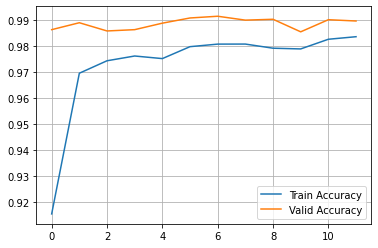

In [17]:
# Plot the loss and accuracy curves for training and validation

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Valid Accuracy")
plt.legend()
plt.grid()
plt.show()

### Confusion Matrix

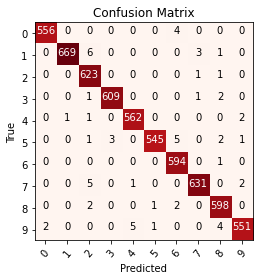

In [15]:
pred_valid = np.argmax(model.predict(X_valid), axis=1) 
plot_confusion_matrix(actual_valid, pred_valid)

###Display Prediction Errors

Should cut them some slack over these badly drawn digits

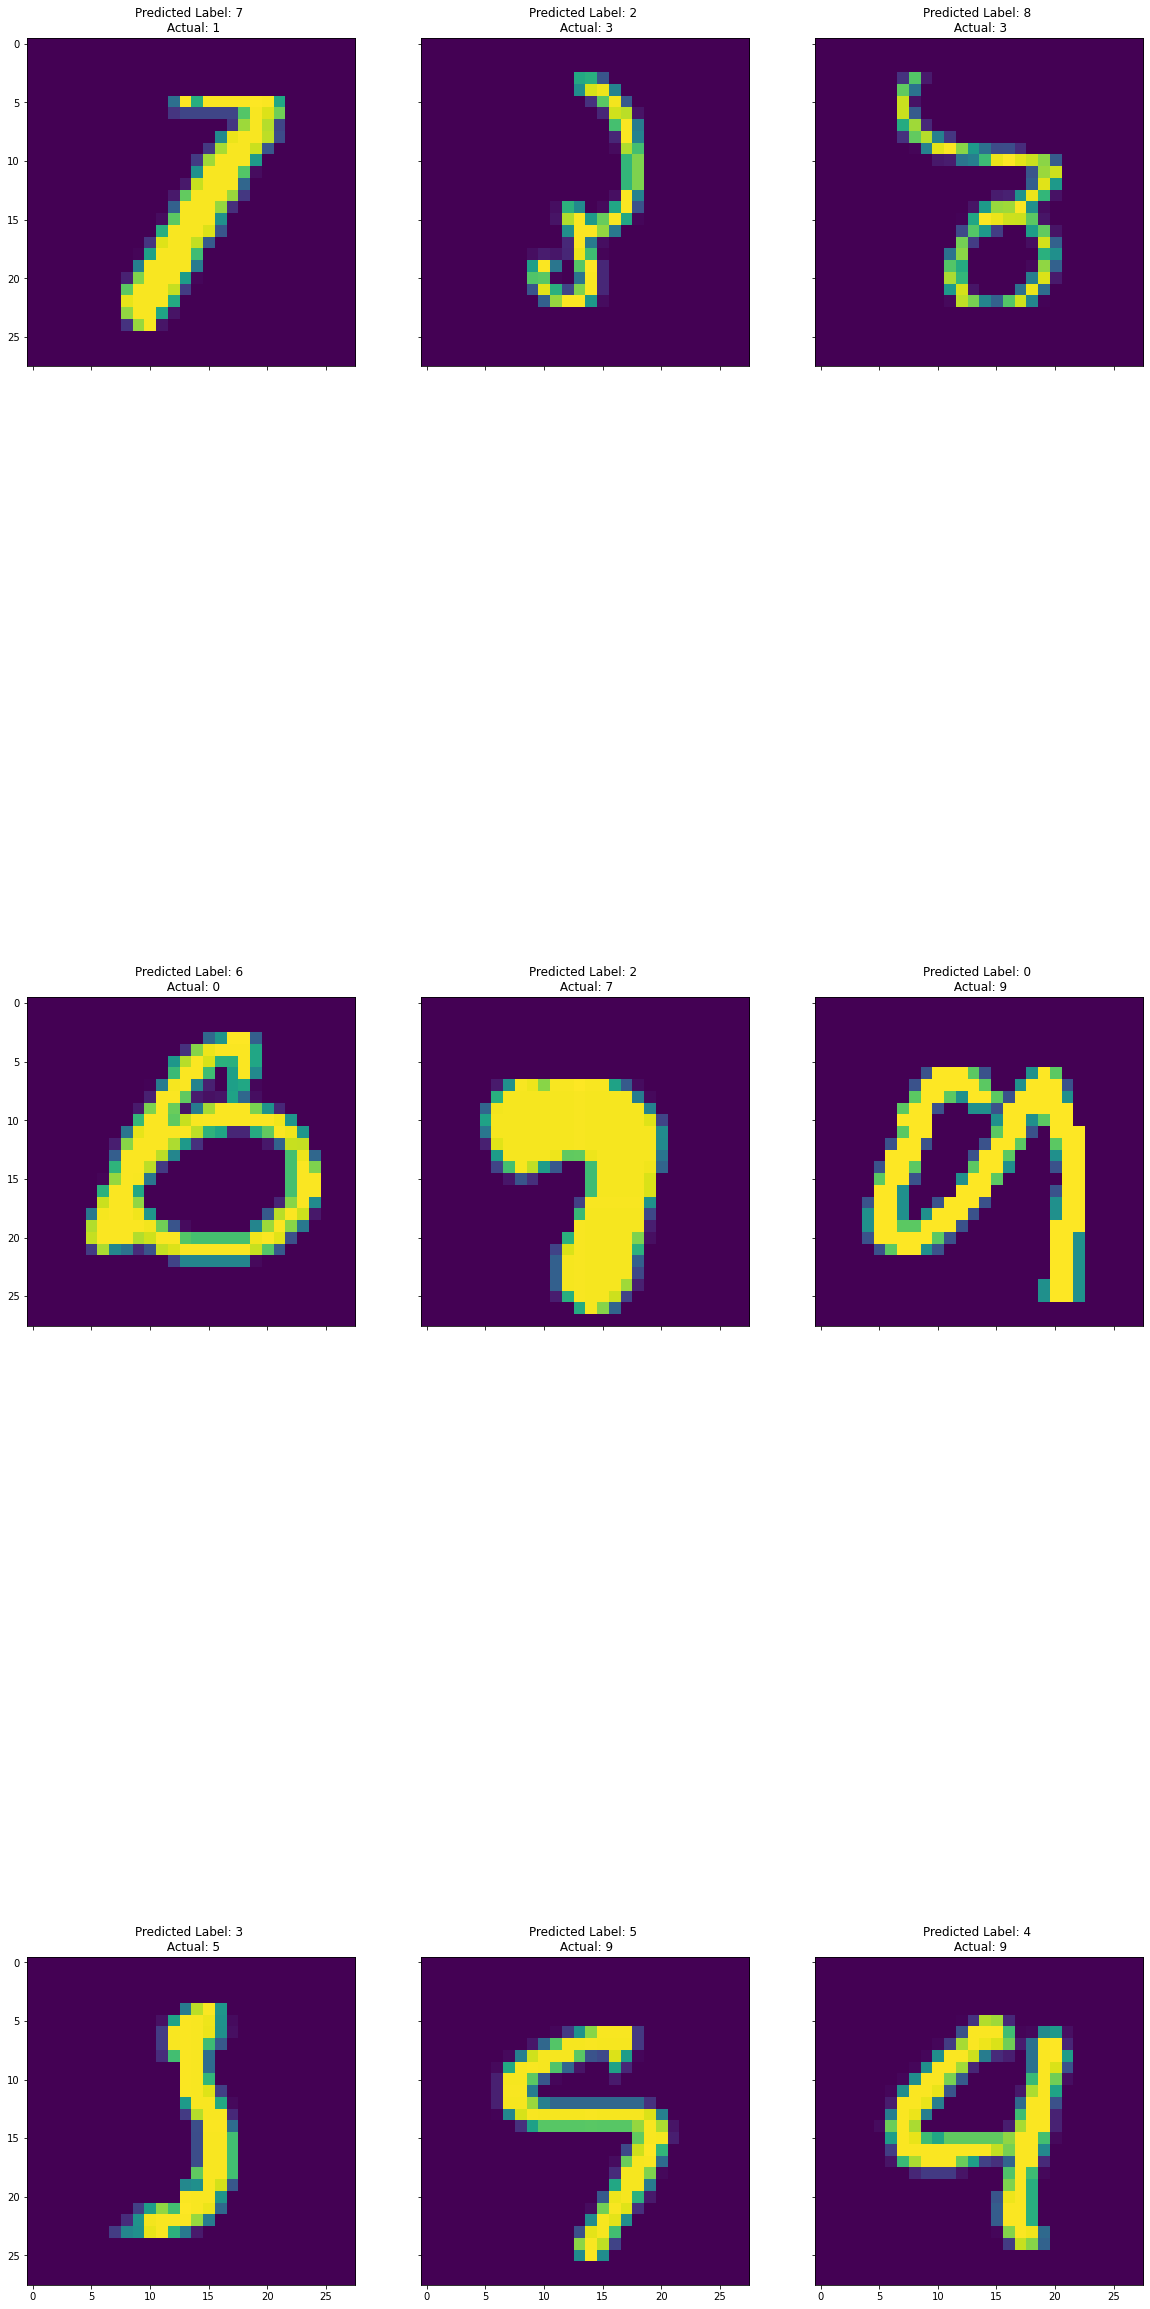

In [16]:
display_errors(X_valid, actual_valid, pred_valid)